# Figure 1 : Example of a packet time series transformed into a flowpic representation for a randomly selected flow

[:simple-jupyter: :material-download:](../../paper_tables_and_figures/figure1_flowpic_example/figure1_flowpic_example.ipynb)

In [1]:
import numpy as np
import tcbench as tcb
from matplotlib.colors import LogNorm, Normalize
from tcbench import dataprep

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import tcbench

In [4]:
# load unfiltered dataset
FLOWPIC_BLOCK_DURATION = 15

In [5]:
df = tcb.load_parquet(tcb.DATASETS.UCDAVISICDM19)

In [6]:
df_sample = df.sample(n=1, random_state=12345)
ser = df_sample.iloc[0]

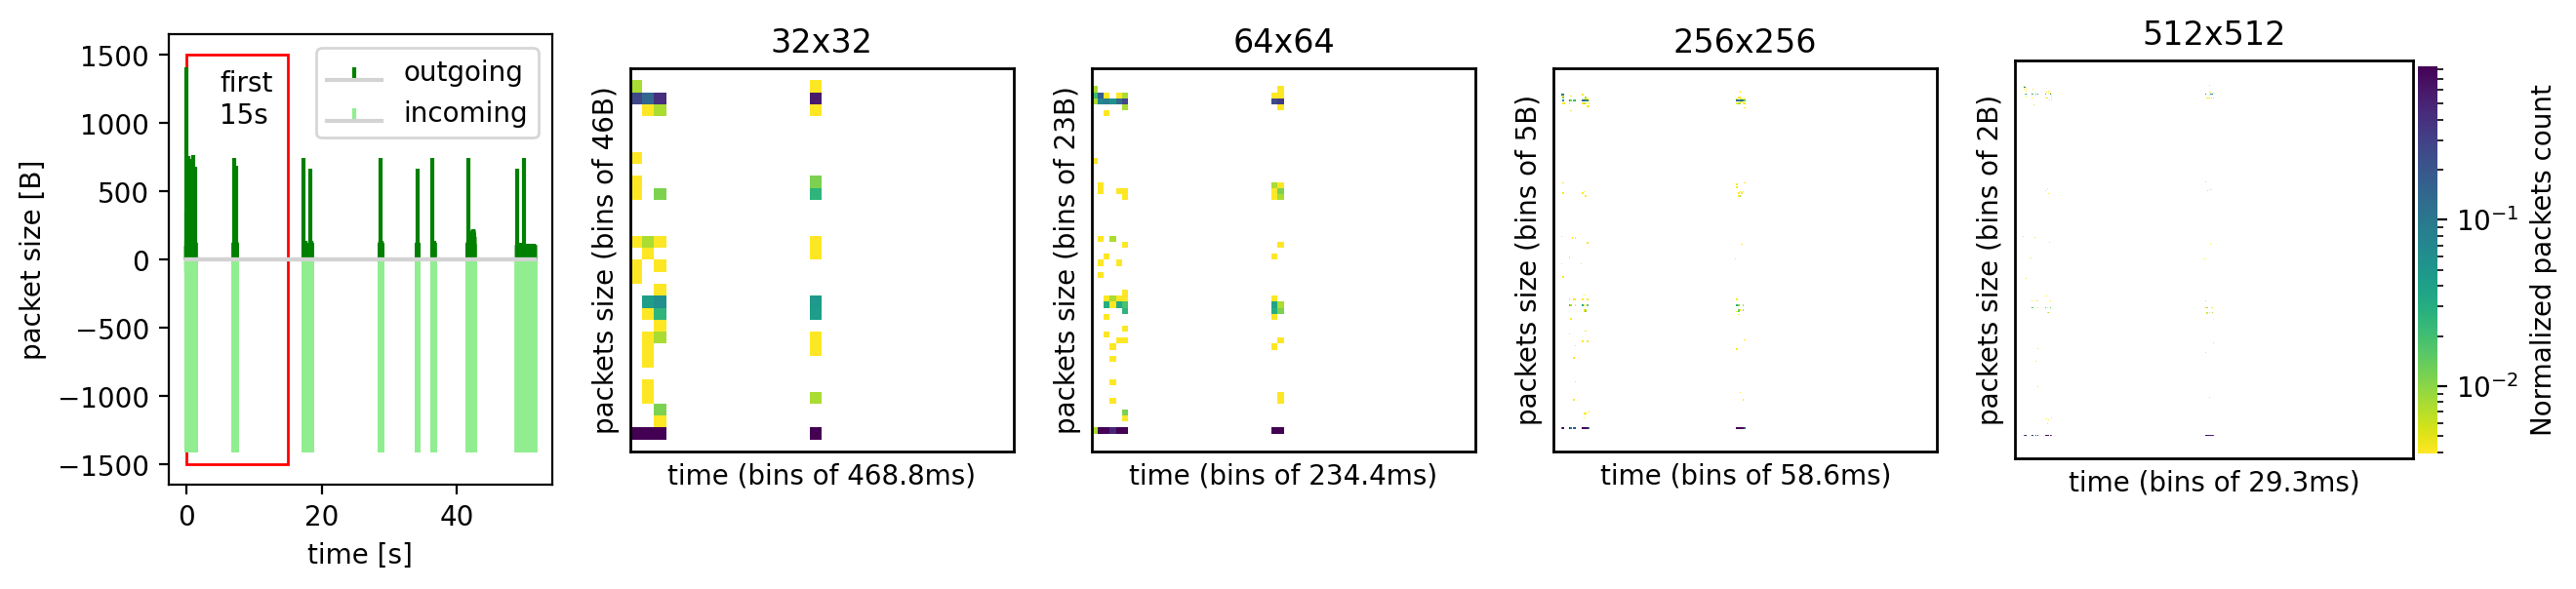

In [9]:
fig, axes = plt.subplots(
    nrows=1, ncols=5, figsize=(15, 3), gridspec_kw=dict(width_ratios=[1, 1, 1, 1, 1.1])
)

direction = np.where(ser["pkts_dir"] == 0, -1, 1)
y = ser["pkts_size"] * direction
x = ser["timetofirst"]

ax = axes[0]
ax.stem(
    np.where(y > 0, x, 0),
    np.where(y > 0, y, 0),
    markerfmt="",
    basefmt="lightgray",
    label="outgoing",
    linefmt="green",
)
ax.stem(
    np.where(y < 0, x, 0),
    np.where(y < 0, y, 0),
    markerfmt="",
    basefmt="lightgray",
    label="incoming",
    linefmt="lightgreen",
)
ax.legend()
ax.set_ylabel("packet size [B]")
ax.set_xlabel("time [s]")

rect = mpl.patches.Rectangle(
    (0, -1500), 15, 3000, linewidth=1, edgecolor="r", facecolor="none"
)
ax.add_patch(rect)
ax.annotate("first\n15s", (5, 1000))

for idx, flowpic_dim in enumerate((32, 64, 256, 512), start=1):
    # create a single sample dataset
    dset = dataprep.FlowpicDataset(
        data=df_sample,
        timetofirst_colname="timetofirst",
        pkts_size_colname="pkts_size",
        pkts_dir_colname="pkts_dir",
        target_colname="app",
        flowpic_dim=flowpic_dim,
        flowpic_block_duration=FLOWPIC_BLOCK_DURATION,
    )

    # fetch the flowpic representation
    flowpic, label = dset[0]

    # flattening the representation
    # to remove zero values (used for finding
    # min values)
    flowpic = flowpic.numpy().squeeze()
    flattened = flowpic.flatten()
    flattened = flattened[flattened > 0]

    ax = axes[idx]

    sns.heatmap(
        ax=ax,
        data=np.where(flowpic == 0, np.nan, flowpic),
        vmin=flattened.min(),
        vmax=flattened.max(),
        cbar=idx == 4,
        cbar_kws=dict(fraction=0.046, pad=0.01, aspect=20, label="Normalized packets count"),
        cmap=plt.get_cmap("viridis_r"),
        square=True,
        norm=LogNorm(flattened.min(), flattened.max()),
    )
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    ax.yaxis.set_ticks([], None)
    ax.xaxis.set_ticks([], None)
    ax.set_ylabel(f"packets size (bins of {1500 // flowpic_dim}B)")
    ax.set_xlabel(f"time (bins of {FLOWPIC_BLOCK_DURATION / flowpic_dim * 1000:.1f}ms)")
    ax.set_title(f"{flowpic_dim}x{flowpic_dim}")

plt.savefig("flowpic_example.png", dpi=300, bbox_inches="tight")